# Binary classification using Transfer Learning

## Split the data randomly

The dataset is organized into two classes i.e., **Focussed**, and **Distracted** drivers. The dataset contains images of 81 individuals doing various tasks and these images are split randomly into 3 parts. That is, 70% of the dataset is used as training set, 20% as Validation set and the rest 10% as test set.

```python
import splitfolders  # import split_folders

input_folder = 'distracted_driver_new/train'


#Train, val, test
splitfolders.ratio(input_folder, output="distracted_driver", 
                   seed=42, ratio=(.7, .2, .1), 
                   group_prefix=None) # default values
```

In [69]:
# import the required libraries
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from sklearn.metrics import accuracy_score

In [3]:
# Checking for GPU
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# To re-size all the images to (224, 224)
IMAGE_SIZE = [224, 224]

In [5]:
# Enter file paths for train, validation and test set
train_path = 'distracted_driver/train'
valid_path = 'distracted_driver/val'
test_path = 'distracted_driver/test'

In [106]:
# Enter one sample test image path for final prediction
sample_test_distracted = 'distracted_driver/test/Distracted/img_5.jpg'
sample_test_focused = 'distracted_driver/test/Focused/img_34.jpg'

In [93]:
# Adding preprocessing layer to the beginning of VGG16
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Adding preprocessing layer to the beginning of ResNet50
resnet50 = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [11]:
def transfer_learning(arch, train_path, valid_path):
    
    # Freezing hidden layers
    for layer in arch.layers:
        layer.trainable = False

    # To get number of classes
    num_folders = glob(train_path + '/*')
    num_classes = len(num_folders)

    # Flatten the VGG/ResNet output and pass it through 2 Dense layers
    x = Flatten()(arch.output)
    x = Dense(1024, activation='relu')(x)
    prediction = Dense(2, activation='softmax')(x)

    # Initialize a model object
    model = Model(inputs=arch.input, outputs=prediction)

    # Compile the model
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    train_datagen = ImageDataGenerator(rescale = 1./255, 
                                       shear_range = 0.2, 
                                       zoom_range = 0.2, 
                                       horizontal_flip = False)

    val_datagen = ImageDataGenerator(rescale = 1./255)

    print("For train set: ")
    train_set = train_datagen.flow_from_directory(train_path, 
                                                  target_size = (224, 224),
                                                  batch_size = 32,
                                                  class_mode = 'categorical')
    
    print("\nFor validation set: ")
    val_set = val_datagen.flow_from_directory(valid_path,
                                              target_size = (224, 224),
                                              batch_size = 32,
                                              class_mode = 'categorical')
    
    # fit the model
    print(f"\nFitting the model...")
    r = model.fit(train_set, 
                  validation_data=val_set, 
                  epochs=5, 
                  steps_per_epoch=len(train_set), 
                  validation_steps=len(val_set))
    return model, r

In [130]:
def loss_acc_plots(r):
    # loss
    epochs = np.arange(1,6)
    plt.figure(figsize=(5, 4), dpi=100)
    plt.plot(epochs, r.history['loss'], label='Train loss')
    plt.plot(epochs, r.history['val_loss'], label='Validation loss')
    plt.title("Train and Validation Loss for every epoch")
    plt.xticks(epochs)
    plt.ylim(0, 1.05)
    plt.legend()
    plt.show();
    
    # accuracies
    plt.figure(figsize=(5, 4), dpi=100)
    plt.plot(epochs, r.history['accuracy'], label='Train accuracy')
    plt.plot(epochs, r.history['val_accuracy'], label='Validation accuracy')
    plt.title("Train and Validation accuracy for every epoch")
    plt.xticks(epochs)
    plt.ylim(0, 1.05)
    plt.legend()
    plt.show();

In [101]:
def get_predictions_and_acc(model, test_path):

    y_pred = [] # Stores predicted class
    
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_set = test_datagen.flow_from_directory(test_path,
                                                target_size = (224, 224),
                                                shuffle=False,
                                                class_mode = 'categorical')
    preds = model.predict(test_set)
    
    for i in preds:
        y_pred.append(np.argmax(i))
        
    # Finding accuracy using sklearn    
    acc = accuracy_score(y_pred, list(test_set.labels))

    return y_pred, acc

In [102]:
def show_sample_img(sample_test):
    image = mpimg.imread(sample_test)
    plt.figure(figsize=(5, 4), dpi=100)
    plt.imshow(image)
    plt.title("Sample test image BEFORE reshaping")
    plt.show();

    #load the image
    my_image = load_img(sample_test, target_size=(224, 224))
    plt.figure(figsize=(5, 4), dpi=100)
    plt.imshow(my_image)
    plt.title("Sample test image AFTER reshaping")
    plt.show();

In [103]:
def sample_predict(model, sample_test): 
    
    #preprocess the image
    my_image = load_img(sample_test, target_size=(224, 224))
    my_image = img_to_array(my_image)
    my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
    my_image = preprocess_input(my_image)

    a = np.argmax(model.predict(my_image))

    if a == 0:
        pred = "Distracted"
    else:
        pred = "Focused"
        
    return pred

## 1) Using VGG16

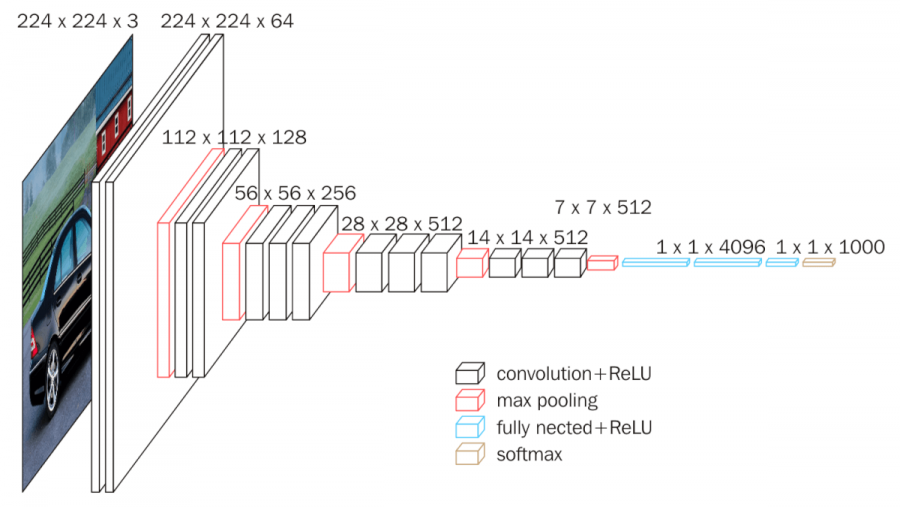

In [12]:
model, r = transfer_learning(vgg, train_path, valid_path)

For train set: 
Found 15697 images belonging to 2 classes.

For validation set: 
Found 4484 images belonging to 2 classes.

Fitting the model...
Epoch 1/5
491/491 [==============================] - 797s 2s/step - loss: 0.3434 - accuracy: 0.9127 - val_loss: 0.0528 - val_accuracy: 0.9795
Epoch 2/5
491/491 [==============================] - 508s 1s/step - loss: 0.0731 - accuracy: 0.9720 - val_loss: 0.0263 - val_accuracy: 0.9891
Epoch 3/5
491/491 [==============================] - 497s 1s/step - loss: 0.0613 - accuracy: 0.9759 - val_loss: 0.0272 - val_accuracy: 0.9906
Epoch 4/5
491/491 [==============================] - 496s 1s/step - loss: 0.0466 - accuracy: 0.9825 - val_loss: 0.0369 - val_accuracy: 0.9866
Epoch 5/5
491/491 [==============================] - 478s 973ms/step - loss: 0.0374 - accuracy: 0.9866 - val_loss: 0.0193 - val_accuracy: 0.9944


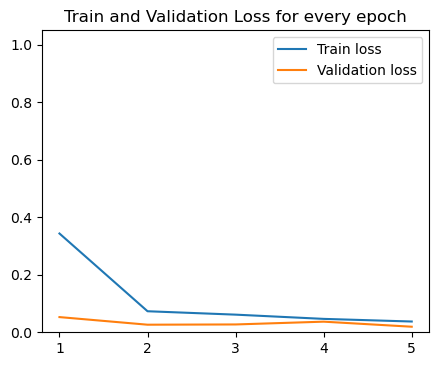

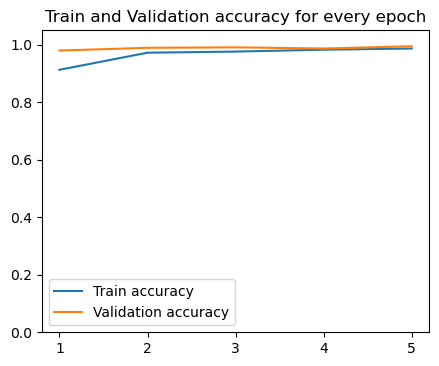

In [131]:
loss_acc_plots(r)

In [68]:
y_pred_vgg, acc_vgg = get_predictions_and_acc(model, test_path)

Found 2244 images belonging to 2 classes.


In [140]:
print(f'Final accuracy using pre-trained VGG16 architecture = {round(acc_vgg*100, 2)} %' )

Final accuracy using pre-trained VGG16 architecture = 99.33 %


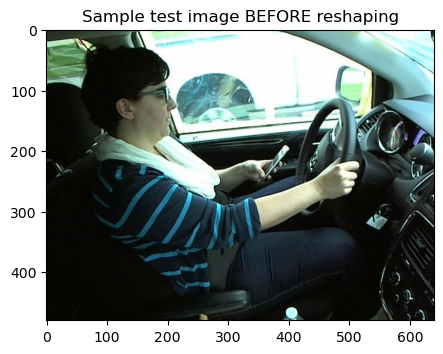

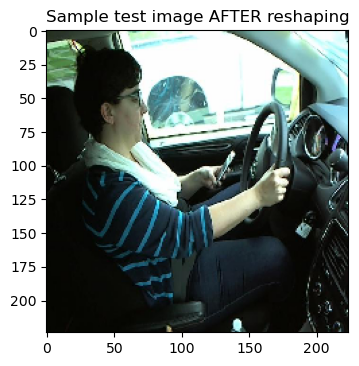

In [107]:
show_sample_img(sample_test_distracted)

In [108]:
print("Predicted class of the sample test image: ", sample_predict(model, sample_test_distracted))

Predicted class of the sample test image:  Distracted


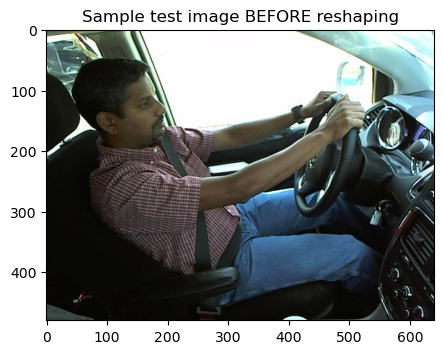

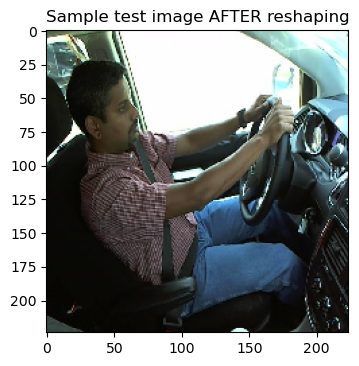

In [109]:
show_sample_img(sample_test_focused)

In [110]:
print("Predicted class of the sample test image: ", sample_predict(model, sample_test_focused))

Predicted class of the sample test image:  Focused


## 2) Using ResNet50

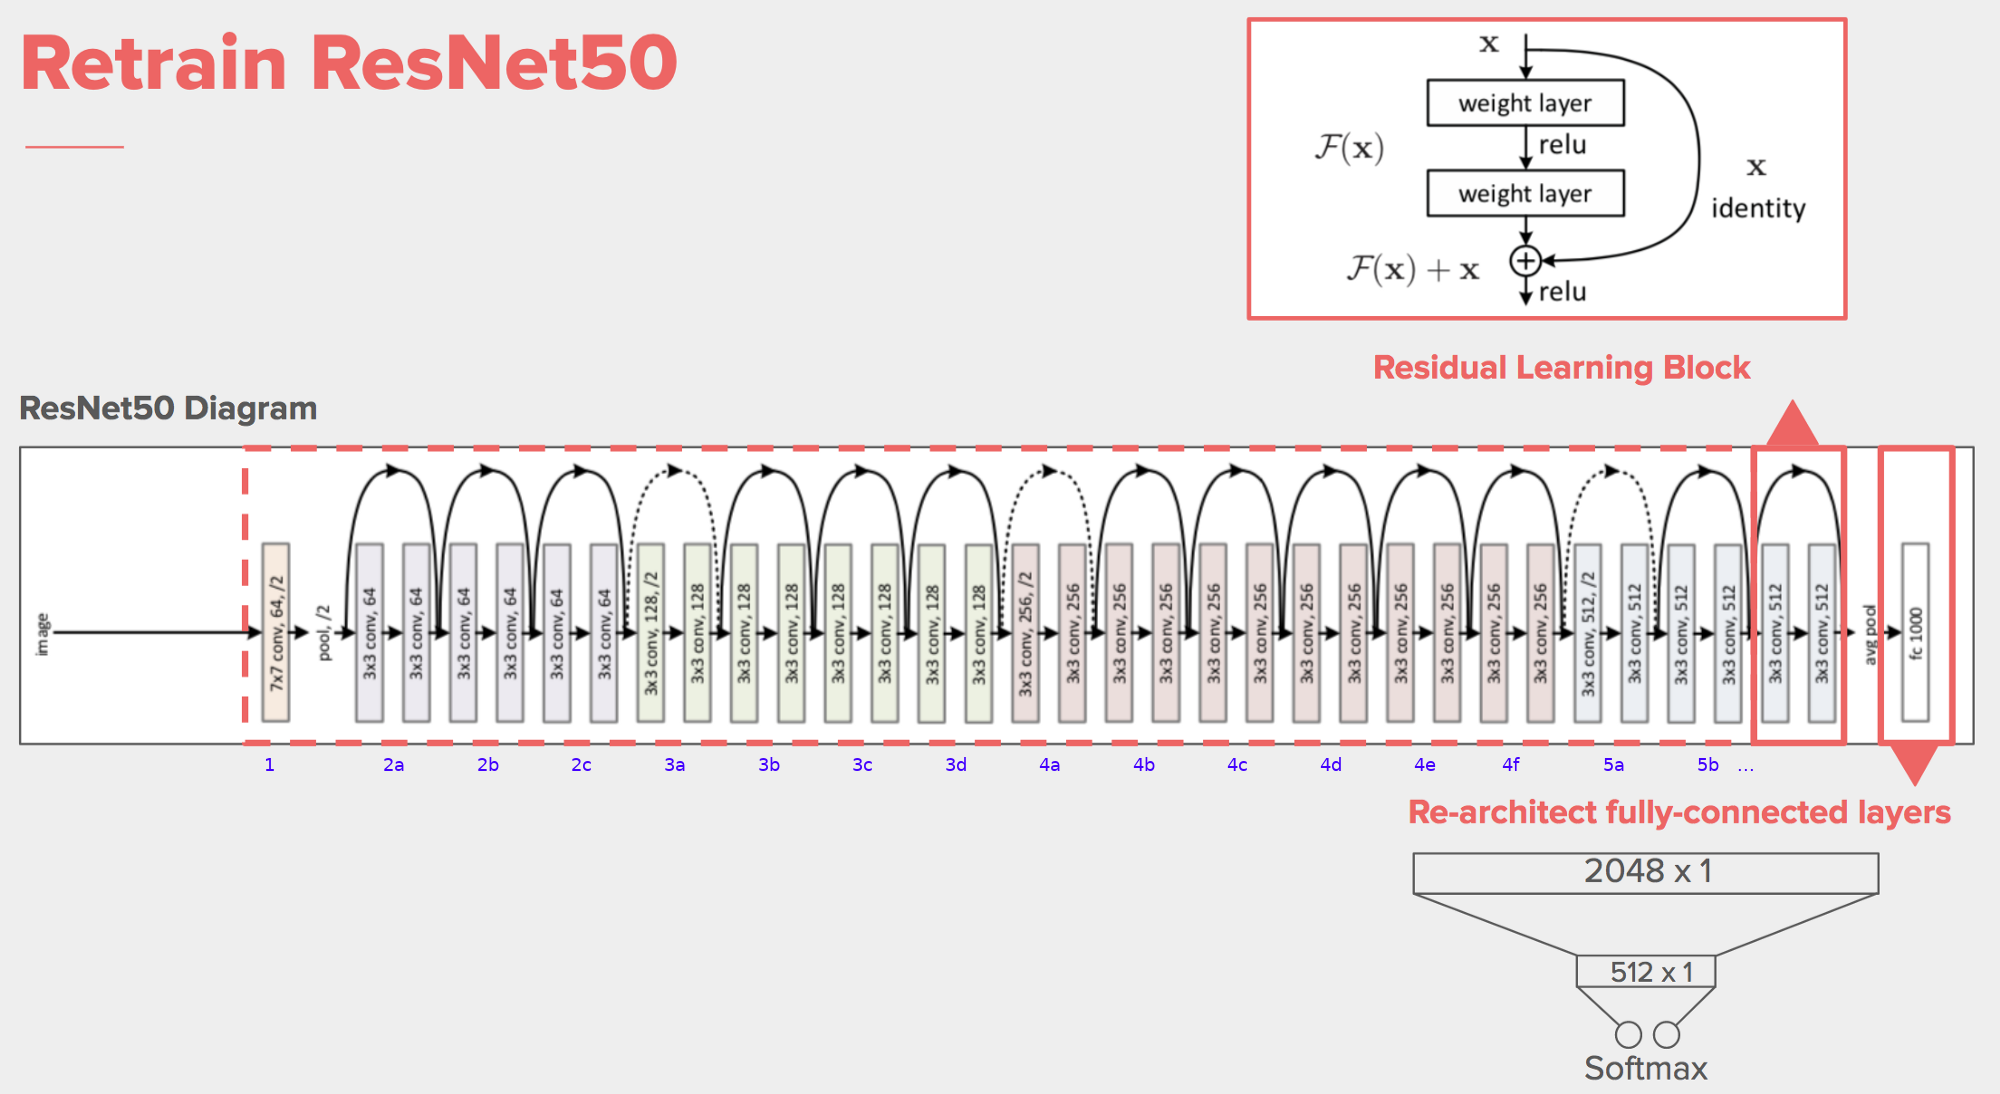

In [94]:
model_resnet, r_resnet = transfer_learning(resnet50, train_path, valid_path)

For train set: 
Found 15697 images belonging to 2 classes.

For validation set: 
Found 4484 images belonging to 2 classes.

Fitting the model...
Epoch 1/5
491/491 [==============================] - 565s 1s/step - loss: 1.0060 - accuracy: 0.6539 - val_loss: 0.4204 - val_accuracy: 0.8243
Epoch 2/5
491/491 [==============================] - 595s 1s/step - loss: 0.5097 - accuracy: 0.7457 - val_loss: 0.5474 - val_accuracy: 0.6835
Epoch 3/5
491/491 [==============================] - 571s 1s/step - loss: 0.4039 - accuracy: 0.8138 - val_loss: 0.3486 - val_accuracy: 0.8521
Epoch 4/5
491/491 [==============================] - 537s 1s/step - loss: 0.3679 - accuracy: 0.8402 - val_loss: 0.5269 - val_accuracy: 0.7431
Epoch 5/5
491/491 [==============================] - 543s 1s/step - loss: 0.3808 - accuracy: 0.8262 - val_loss: 0.4970 - val_accuracy: 0.7364


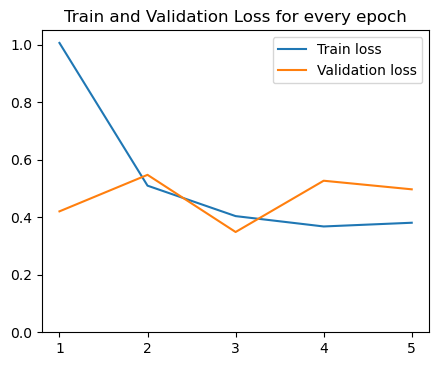

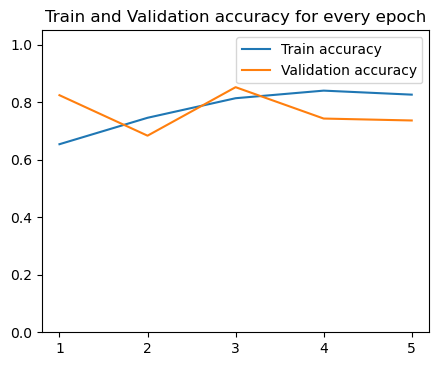

In [132]:
loss_acc_plots(r_resnet)

In [133]:
y_pred_resnet, acc_resnet = get_predictions_and_acc(model_resnet, test_path)

Found 2244 images belonging to 2 classes.


In [138]:
print(f'Final accuracy using pre-trained ResNet50 architecture = {round(acc_resnet*100, 2)} %' )

Final accuracy using pre-trained ResNet50 architecture = 73.93 %


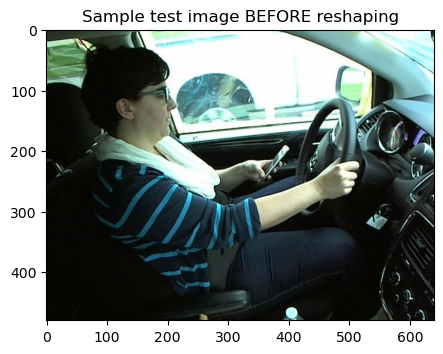

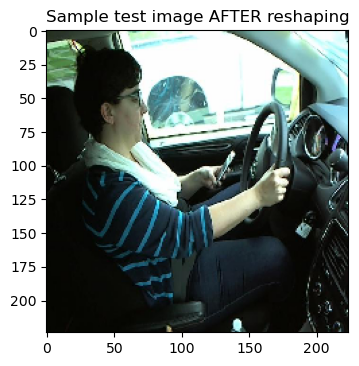

In [135]:
show_sample_img(sample_test_distracted)

In [136]:
print("Predicted class of the sample test image: ", sample_predict(model_resnet, sample_test_distracted))

Predicted class of the sample test image:  Distracted


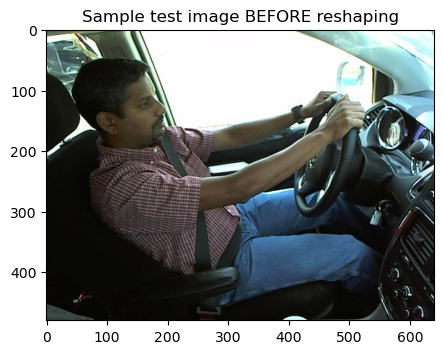

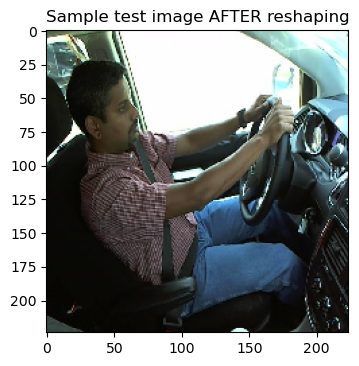

In [137]:
show_sample_img(sample_test_focused)

In [138]:
print("Predicted class of the sample test image: ", sample_predict(model_resnet, sample_test_focused))

Predicted class of the sample test image:  Focused
